# Introduction
Contains the initial investigation of the data before more in-depth analysis

### Includes:
- Histograms 
- Probplot (Q-Q)


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import mplleaflet
from windrose import WindroseAxes
import numpy as np
import shapely
import shapely.wkt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as sma
import scipy.stats as stats
import pylab
import sys
sys.path.append('../utils')
import direction_functions # functions for calculating direction and magnitude of linestrings

%matplotlib inline

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was d

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")
city_of_montreal = mtl_greater[mtl_greater.CSDNAME == "Montral"]
canada_regions = gpd.read_file("../shapes/canada_regions/lpr_000b16a_e.shp")

In [3]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.reset_index(drop=True)

In [4]:
# convert the point columns back into a Point class
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

In [5]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [6]:
CAN_LAM = {'init': 'epsg:3347'}
WGS_84 = {'init':'epsg:4326'}

In [ ]:
# canada_regions = canada_regions.to_crs(CAN_LAM)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
world.plot(ax=ax, alpha=.5, color='white', edgecolor='black')
plt.plot(-73.5673, 45.5017, color='r', marker='o')
plt.ylim(20,90)
plt.xlim(-150,-40)

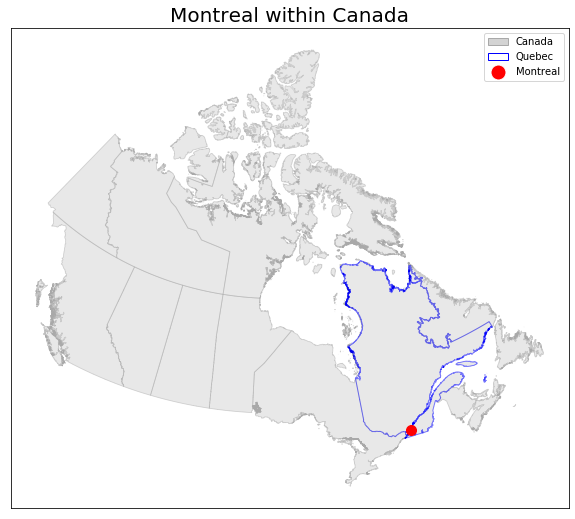

In [172]:
fig, ax = plt.subplots(1, figsize=(10,10))
canada_regions.loc[canada_regions['PRENAME'] != 'Quebec'].plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=.5, linewidth=.8)
canada_regions.loc[canada_regions['PRENAME'] == 'Quebec'].plot(ax=ax, color='lightgrey', edgecolor='b',alpha=.5)
ax.plot(7624029.565886399,1247375.825611254, color='r', marker='o', markersize=10)
red_patch = mpatches.Patch(facecolor='lightgrey', edgecolor='darkgrey', label='Canada')
yellow_patch = mpatches.Patch(facecolor='white', edgecolor='b', label='Quebec')
red_circle = Line2D([0], [0], marker='o', color='w', label='Montreal',
                        markerfacecolor='r', markersize=15)
ax.legend(handles=[red_patch, yellow_patch, red_circle])
plt.xticks([]);
plt.yticks([]);
ax.set_title("Montreal within Canada", size=20)
# plt.savefig('figures/montreal_within_canada.png', bbox_inches='tight')

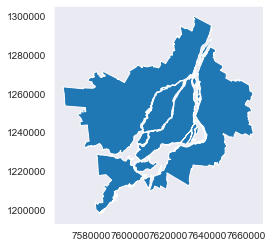

In [13]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)
mtl_greater.dissolve(by="CMANAME").plot()

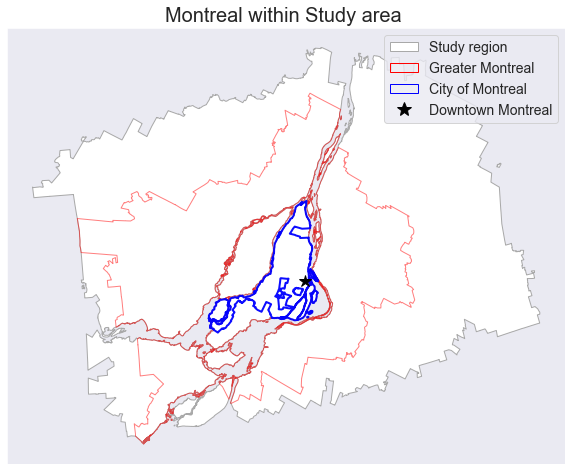

In [29]:
sns.set_style('dark')
fig, ax = plt.subplots(1, figsize=(10,10))
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='white', edgecolor='darkgrey', alpha=1)
# mtl_dissem.plot(ax=ax, color='white', edgecolor='darkgrey', alpha=1)
#mtl_greater.dissolve(by="CMANAME")
mtl_greater.dissolve(by="CMANAME").plot(ax=ax, color='None', edgecolor='red', linewidth=1, alpha=.5)
city_of_montreal.plot(ax=ax, color='None', edgecolor='blue', linewidth=2, alpha=.95)
# gdf.plot(ax=ax, color='m', alpha=.5)
plt.plot(7631671.440715431, 1245240.295997527, '*', color='k', markersize=12)
red_patch = mpatches.Patch(facecolor='white', edgecolor='darkgrey', label='Study region')
yellow_patch = mpatches.Patch(facecolor='None', edgecolor='red', label='Greater Montreal')
blue_patch = mpatches.Patch(facecolor='None', edgecolor='b', label='City of Montreal')
magenta_star = Line2D([0], [0], marker='*', color='k', label='Downtown Montreal',
                        markerfacecolor='k',linestyle = 'None', markersize=15)


ax.legend(handles=[red_patch, yellow_patch, blue_patch, magenta_star], fontsize=14)
plt.xticks([]);
plt.yticks([]);
ax.set_title("Montreal within Study area ", size=20)
# plt.savefig('figures/study_area_map_alt2.png', bbox_inches='tight')

In [ ]:
len(mtl_dissem)

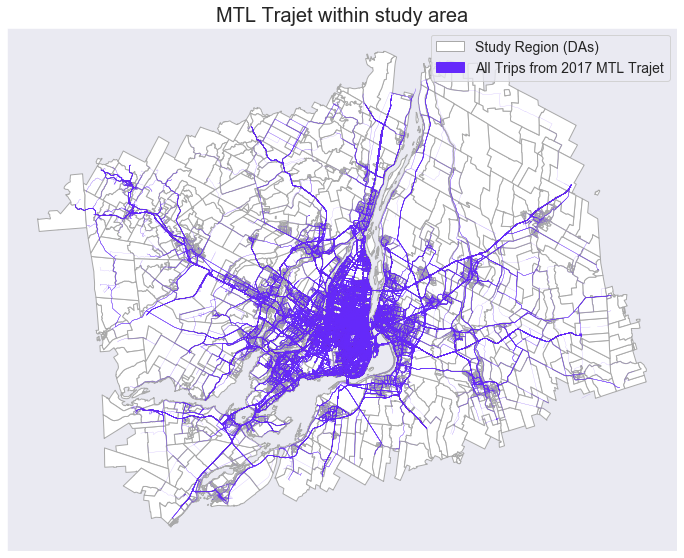

In [30]:
sns.set_style('dark')
fig, ax = plt.subplots(1, figsize=(12,10))
mtl_dissem.plot(ax=ax, color='white', edgecolor='darkgrey', alpha=1)
gdf.plot(ax=ax, color='#6529fb', alpha=.5, linewidth=.2)
red_patch = mpatches.Patch(facecolor='white', edgecolor='darkgrey', label='Study Region (DAs)')
magenta_patch = mpatches.Patch(color='#6529fb', label='All Trips from 2017 MTL Trajet')
ax.legend(handles=[red_patch, magenta_patch], fontsize=14);
plt.xticks([]);
plt.yticks([]);
ax.set_title("MTL Trajet within study area", size=20)
# plt.savefig('figures/mtl_trajet_within_alt.png', bbox_inches='tight')

## General Info about dataset

In [11]:
## 74,218 values that have a mode and purpose
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 185285 entries, 0 to 185284
Data columns (total 15 columns):
id_trip       185285 non-null int64
mode          74218 non-null object
purpose       74218 non-null object
starttime     185285 non-null object
endtime       185285 non-null object
seconds       185285 non-null int64
distance_m    185285 non-null float64
direction     185285 non-null float64
magnitude     185285 non-null float64
carddir       185285 non-null object
start_wgs     185285 non-null object
end_wgs       185285 non-null object
start_can     185285 non-null object
end_can       185285 non-null object
geometry      185285 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.2+ MB
None


In [12]:
gdf

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,1.900323e-02,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,3.135046e-01,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,2.721037e-01,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,3.040857e-01,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,2.554853e-01,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...
5,421155,None,None,2017-09-18 06:42:13-04:00,2017-09-18 06:45:16-04:00,183,530.737088,66.286377,3.251784e-01,ENE,POINT (-73.45155700000004 45.74749099999982),POINT (-73.44648500000002 45.7488929999998),POINT (7632650.98172996 1273797.68928672),POINT (7632989.362858895 1274063.356276445),"LINESTRING (7632650.98172996 1273797.68928672,..."
6,29064,None,None,2017-09-18 06:47:52-04:00,2017-09-18 06:49:34-04:00,102,90.537212,225.258580,4.075197e-01,SW,POINT (-73.56574500000005 45.51009499999979),POINT (-73.56641300000003 45.51001499999981),POINT (7631610.128197737 1245567.675562556),POINT (7631561.883890274 1245543.987149366),(LINESTRING (7631626.545535451 1245629.5916483...
7,203781,None,None,2017-09-18 06:53:49-04:00,2017-09-18 07:16:31-04:00,1362,8605.960727,123.191659,3.256624e-01,ESE,POINT (-73.56183100000007 45.51437399999979),POINT (-73.56330200000005 45.51500699999978),POINT (7631770.802031942 1246118.630389794),POINT (7631638.671248137 1246153.989722969),(LINESTRING (7623626.441304226 1247943.3070560...
8,273549,None,None,2017-09-18 06:54:50-04:00,2017-09-18 07:08:43-04:00,833,11432.721024,13.240337,2.935558e-01,NNE,POINT (-73.44588800000005 45.7523189999998),POINT (-73.42086200000004 45.82959999999981),POINT (7632924.248795619 1274446.797314812),POINT (7632326.330171747 1283354.4540747),LINESTRING (7632924.248795619 1274446.79731481...
9,314196,None,None,2017-09-18 06:57:01-04:00,2017-09-18 07:23:51-04:00,1610,7770.617747,34.373388,2.572517e-01,NE,POINT (-73.66851600000004 45.44199299999978),POINT (-73.62876200000002 45.47846499999979),POINT (7625960.44123376 1235889.569612722),POINT (7627825.844729592 1240729.001491461),LINESTRING (7625960.44123376 1235889.569612722...


In [13]:
## 1 month worth of data mid-September to mid-October
print(gdf.starttime.min(),"\n", gdf.starttime.max())

2017-09-18 00:16:58-04:00 
 2017-10-17 23:50:08-04:00


In [14]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


In [15]:
# total of 11 unique travel purposes
gdf['purpose'].unique()

array([None, 'pick_up_a_person', 'work', 'shops', 'returning_home',
       'health', 'leisure', 'education', 'other', 'cafe', 'not_available'],
      dtype=object)

In [16]:
# total of 70 unique travel modes
gdf['mode'].unique()

array([None, 'car', 'walking, public_transport', 'public_transport',
       'walking', 'cycling', 'walking, public_transport, cycling',
       'public_transport, car', 'walking, cycling',
       'walking, car, cycling', 'car_sharing', 'other',
       'public_transport, cycling', 'walking, public_transport, car',
       'public_transport, car, cycling', 'walking, car', 'car, cycling',
       'taxi', 'not_available', 'taxi, cycling',
       'walking, car_sharing, cycling',
       'car_sharing, public_transport, car', 'taxi, car',
       'walking, car_sharing, car', 'car_sharing, other',
       'walking, taxi, cycling', 'car_sharing, taxi', 'car_sharing, car',
       'car_sharing, other, car', 'car_sharing, public_transport',
       'walking, public_transport, car, cycling',
       'other, public_transport', 'walking, other, public_transport',
       'other, cycling', 'other, taxi',
       'walking, car_sharing, other, public_transport', 'walking, other',
       'other, car', 'walking, ta

## descriptive statistics

In [20]:
i = 'seconds' # distance_m
q75, q25 = np.percentile(gdf[i].dropna(), [75 ,25])
iqr = q75 - q25

mina = q25 - (iqr*1.5)
maxa = q75 + (iqr*1.5)
maxa

4258.5

In [26]:
i = 'distance_m' # 
q75, q25 = np.percentile(gdf[i].dropna(), [75 ,25])
iqr = q75 - q25

mina = q25 - (iqr*1.5)
maxa = q75 + (iqr*1.5)

# # fig, ax = plt.subplots(2, 1, sharex=True)

# plt.xlim(df[i].min(), df[i].max()*1.1)
# plt.axvline(x=mina)
# plt.axvline(x=maxa)
# plt.xticks(size=12);
# plt.ylabel("Density",size=16);
 
# # ax1 = df[i].plot(kind='kde', ax=ax[0])
 
# plt.subplot(212)
# plt.xlim(0, df[i].max()*1.1)
# sns.boxplot(x=df[i])
# plt.axvline(x=mina)
# plt.axvline(x=maxa)
# plt.text(maxa,-0.52,'Upper Tukey Fence', color='#0544aa')
# plt.text(mina,-0.52,'Lower', color='#0544aa')
# plt.xticks(size=12);
# plt.xlabel("KSI per persons (2009)",size=16);

18571.531116568658

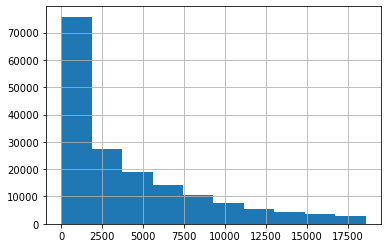

In [27]:
gdf.loc[gdf.distance_m <= maxa].distance_m.hist()

In [259]:
# original == 185285
# after distance 6709
# after duration 412
# after both 178383
# after all 177938

178383

In [299]:
gdf[["distance_m", "seconds"]].describe().T
### journeytime  -> 
### min 1 second
### 25% is around 10 mins
### median is 19 mins
### 75% is 34 mins
### max is 1397 mins or 23 hours
### conclusion -> heavily tailed, so maybe use tukey-fences to remove

### distance  -> 
### min 0 m (*WILL NEED TO BE REMOVED)
### 25% is around 2.9 km
### median is 19 mins
### 75% is 7.8 km
### max is 282 km
### conclusion -> heavily tailed, so maybe use tukey-fences to remove

,count,mean,std,min,25%,50%,75%,max
distance_m,177938.0,6634.984415,9927.291154,50.007612,840.664359,3147.598183,8092.656898,99810.933147
seconds,177938.0,1537.695787,1285.633778,60.000000,616.000000,1204.000000,2081.000000,10799.000000


In [243]:
max(gdf["distance_m"] / gdf["seconds"])

138.1338492653218

In [22]:
print("Journeytime 99th quantile is:", gdf.seconds.quantile(.99), "seconds")
print("Distance 99th quantile is:", gdf.distance_m.quantile(.99), "m")

Journeytime 99th quantile is: 6621.0 seconds
Distance 99th quantile is: 52034.68842420046 m


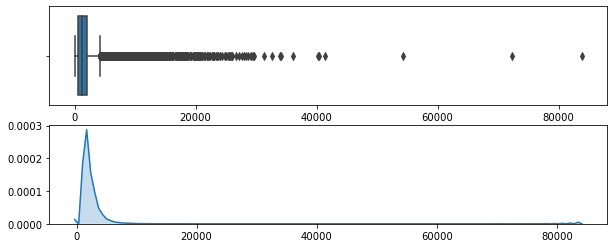

In [117]:
fig, (ax,ax2) = plt.subplots(2,1, figsize=(10,4))
sns.boxplot(gdf.seconds, ax=ax, whis=1.5) 
sns.kdeplot(gdf.seconds, ax=ax2, legend=False, shade=True) 
### whis == Proportion of the IQR past the low and high quartiles to extend the  
### plot whiskers. Points outside this range will be identified as outliers.

#### missing values

In [4]:
no_purpose = gdf.loc[gdf.purpose.isna()] # same as no_mode
purpose = gdf.loc[~gdf.purpose.isna()] # same as no_mode

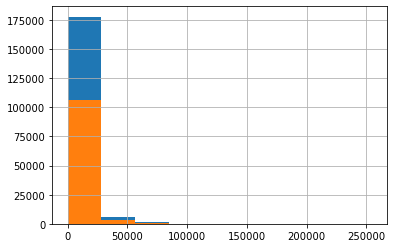

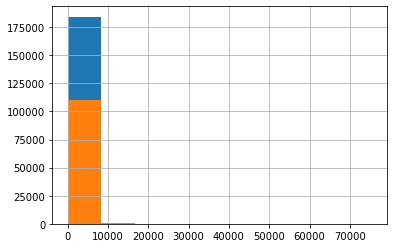

In [26]:
gdf.distance_m.hist(bins=np.arange(0,gdf.distance_m.max(),gdf.distance_m.max()/10 ))
no_purpose.distance_m.hist(bins=np.arange(0,gdf.distance_m.max(),gdf.distance_m.max()/10 ))
plt.show()

gdf.seconds.hist(bins=np.arange(0,gdf.seconds.max(),gdf.seconds.max()/10 ))
no_purpose.seconds.hist(bins=np.arange(0,gdf.seconds.max(),gdf.seconds.max()/10 ))
plt.show()

Text(0, 0.5, 'probability (journeytime (secs))')

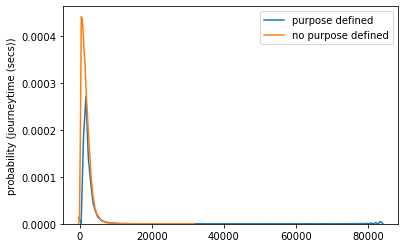

In [27]:
sns.kdeplot(no_purpose.seconds)
sns.kdeplot(purpose.seconds)
plt.legend(['purpose defined','no purpose defined'])
plt.ylabel('probability (journeytime (secs))')

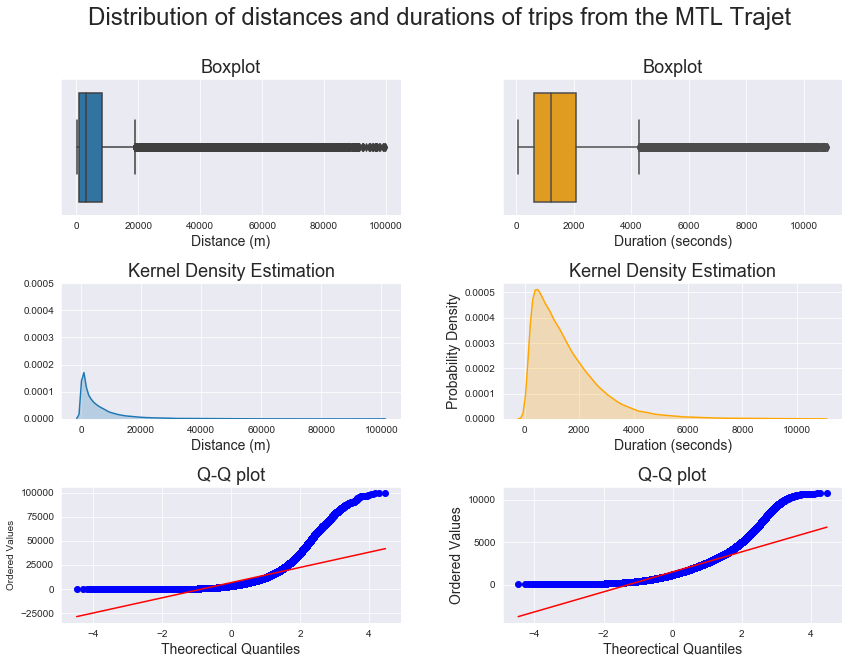

In [12]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(3,2, figsize=(14,10))
plt.subplots_adjust(hspace=.5, wspace=.3)
plt.suptitle("Distribution of distances and durations of trips from the MTL Trajet", size=24)

sns.boxplot(gdf.seconds, ax=ax[0][1], color='orange')
sns.kdeplot(gdf.seconds, ax=ax[1][1], shade=True, color='orange', legend=False);
stats.probplot(gdf.seconds, plot=ax[2][1]);
ax[1][1].set_ylabel("Probability Density", size=14)
ax[2][1].set_ylabel("Ordered Values", size=14)
ax[0][1].set_xlabel("Duration (seconds)", size=14)
ax[1][1].set_xlabel("Duration (seconds)", size=14)
ax[2][1].set_xlabel("Theorectical Quantiles", size=14)
ax[2][1].set_title("")

sns.boxplot(gdf.distance_m, ax=ax[0][0])
sns.kdeplot(gdf.distance_m, ax=ax[1][0], shade=True, legend=False);
stats.probplot(gdf.distance_m, plot=ax[2][0]);
ax[1][0].set_ylim(0,0.0005)
# ax[1][1].set_ylabel("", size=14)
ax[1][0].set_yticks(np.arange(0,0.0006, 0.0001))
# ax[1][1].set_yticklabels("", size=14)
# ax[2][1].set_ylabel("Ordered Values", size=14)
ax[0][0].set_xlabel("Distance (m)", size=14)
ax[1][0].set_xlabel("Distance (m)", size=14)
ax[2][0].set_xlabel("Theorectical Quantiles", size=14)
# plt.suptitle("Distribution of trip distances", size=24)
ax[2][0].set_title("")

ax[0][0].set_title("Boxplot", size=18)
ax[0][1].set_title("Boxplot", size=18)
ax[1][0].set_title("Kernel Density Estimation", size=18)
ax[1][1].set_title("Kernel Density Estimation", size=18)
ax[2][0].set_title("Q-Q plot", size=18)
ax[2][1].set_title("Q-Q plot", size=18)
# plt.savefig("figures/dist_duration_distance.png",bbox_inches='tight')

In [91]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

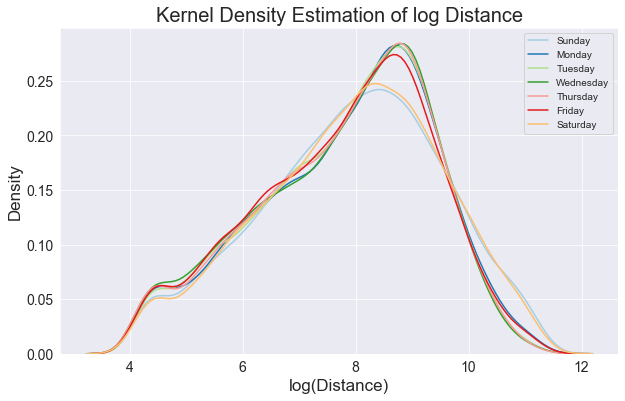

In [116]:
Labels = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
Colors = sns.color_palette("Paired", len(Labels))   #Colors used for each month
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(10,6))
for l, c in zip(Labels, Colors):
    sns.distplot(gdf.loc[gdf.starttime.apply(lambda row: row.day_name() == l)].log_dist, hist=False, label = l, color = c)
plt.legend(loc=1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("log(Distance)", size=17)
plt.ylabel("Density", size=17)
plt.title("Kernel Density Estimation of log Distance", size=20)
# plt.savefig("figures/log_dist_day_kde.png", bbox_inches='tight')

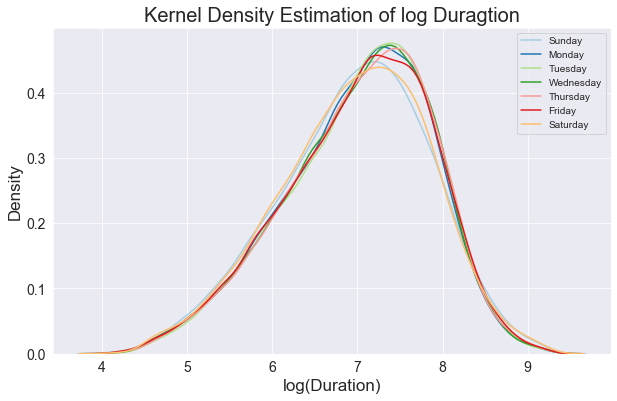

In [119]:
Labels = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
Colors = sns.color_palette("Paired", len(Labels))   #Colors used for each month
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(10,6))
for l, c in zip(Labels, Colors):
    sns.distplot(gdf.loc[gdf.starttime.apply(lambda row: row.day_name() == l)].log_dur, hist=False, label = l, color = c)
plt.legend(loc=1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("log(Duration)", size=17)
plt.ylabel("Density", size=17)
plt.title("Kernel Density Estimation of log Duragtion", size=20)
# plt.savefig("figures/log_dur_day_kde.png", bbox_inches='tight')

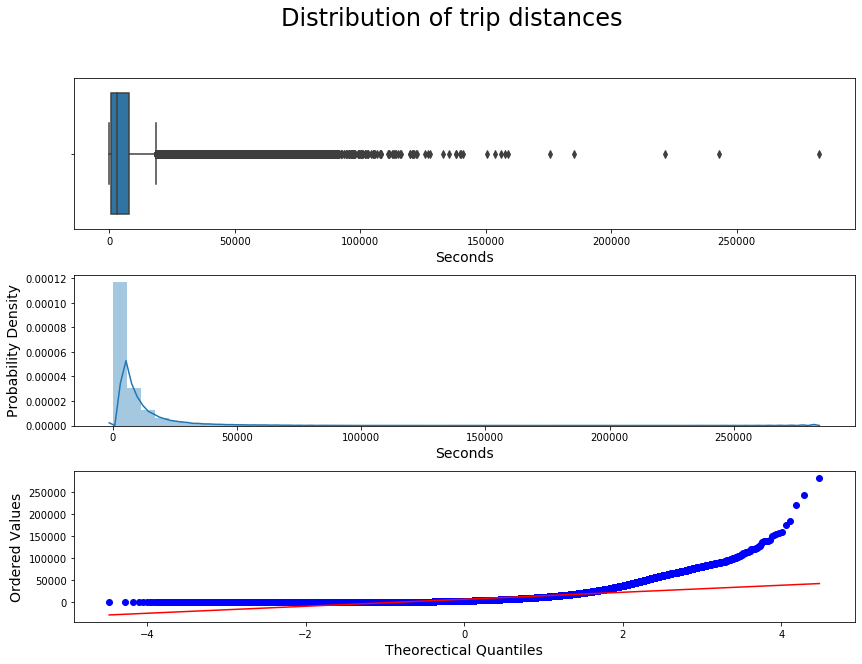

In [142]:
fig, ax = plt.subplots(3,1, figsize=(14,10))
plt.subplots_adjust(hspace=.3)
sns.boxplot(gdf.distance_m, ax=ax[0])
sns.distplot(gdf.distance_m, ax=ax[1]);
stats.probplot(gdf.distance_m, plot=ax[2]);
ax[1].set_ylabel("Probability Density", size=14)
ax[2].set_ylabel("Ordered Values", size=14)
ax[0].set_xlabel("Seconds", size=14)
ax[1].set_xlabel("Seconds", size=14)
ax[2].set_xlabel("Theorectical Quantiles", size=14)
plt.suptitle("Distribution of trip distances", size=24)
ax[2].set_title("")
# plt.savefig("figures/dist_distance.png",bbox_inches='tight')

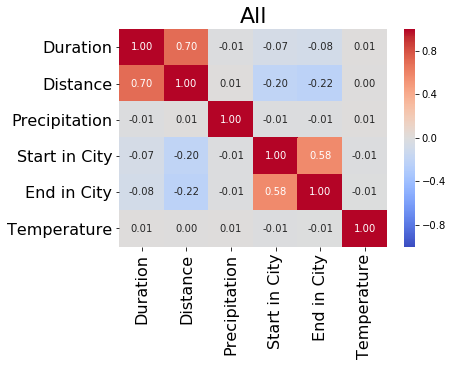

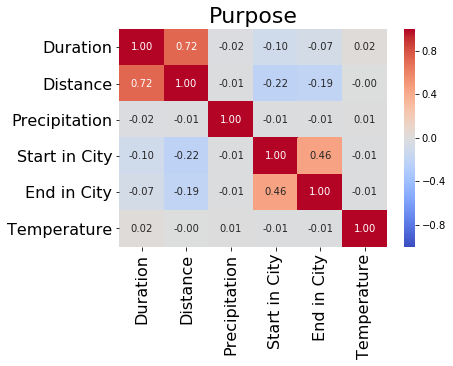

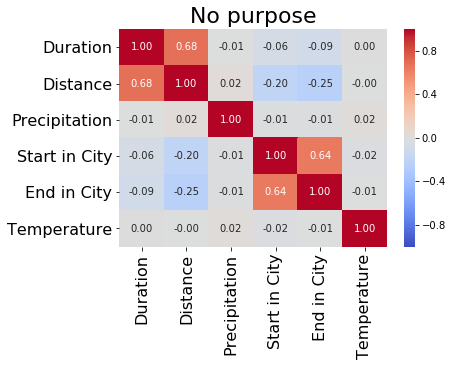

In [48]:
ax = sns.heatmap(gdf[["seconds","distance_m","precip","start_down","end_downto","temperatur"]].corr('spearman'), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax.set_yticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax.set_title("All", size=22)
# plt.savefig("figures/corrmatrix_all.png", bbox_inches='tight')
plt.show()
ax1 = sns.heatmap(purpose[["seconds","distance_m","precip","start_down","end_downto","temperatur"]].corr('spearman'), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
ax1.set_xticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax1.set_yticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax1.set_title("Purpose", size=22)
# plt.savefig("figures/corrmatrix_purpose.png", bbox_inches='tight')
plt.show()
ax2 = sns.heatmap(no_purpose[["seconds","distance_m","precip","start_down","end_downto","temperatur"]].corr('spearman'), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
ax2.set_xticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax2.set_yticklabels(labels=["Duration","Distance","Precipitation","Start in City","End in City","Temperature"],size=16)
ax2.set_title("No purpose", size=22)
# plt.savefig("figures/corrmatrix_no_purpose.png", bbox_inches='tight')


In [14]:
gdf.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'lda_word', 'temporal_c', 'precip', 'temperatur',
       'land_use', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry'],
      dtype='object')

#### distance and time

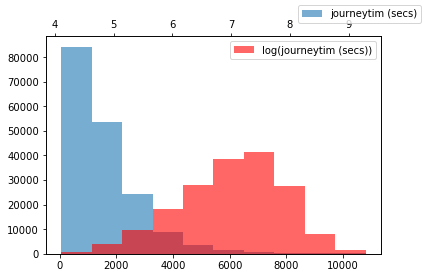

In [55]:
fig, ax = plt.subplots(1)
ax.hist(gdf.seconds, alpha=.6)
ax2 = ax.twiny()
ax2.hist(np.log(gdf.seconds+1), color='r', alpha=.6)
plt.legend(['log(journeytim (secs))'])
plt.gcf().legend(['journeytim (secs)'])

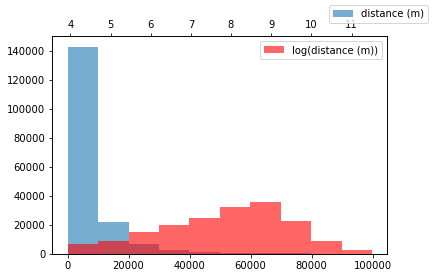

In [56]:
fig, ax = plt.subplots(1)
ax.hist(gdf.distance_m, alpha=.6)
ax2 = ax.twiny()
ax2.hist(np.log(gdf.distance_m+1), color='r', alpha=.6)
plt.legend(['log(distance (m))'])
plt.gcf().legend(['distance (m)'])

In [189]:
def r2(x, y):
    ## pearson's r squared for the linear regression
    return stats.pearsonr(x, y)[0] ** 2

In [8]:
gdf['log_dur'] = np.log(gdf.seconds+1)
gdf['log_dist'] = np.log(gdf.distance_m+1)

In [9]:
reg = sma.ols('distance_m ~ seconds', data=gdf).fit()
reg_log = sma.ols('log_dur ~ log_dist', data=gdf).fit()

In [6]:
print("skew:",stats.skew(gdf.log_dist), "kurtosis:",stats.kurtosis(gdf.log_dist))
print("skew:",stats.skew(gdf.log_dur), "kurtosis:",stats.kurtosis(gdf.log_dur))

skew: -0.37300090670060865 kurtosis: -0.5147541361828902
skew: -0.38136680556957275 kurtosis: -0.21730048341457042


In [122]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             distance_m   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 7.208e+04
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:01:58   Log-Likelihood:            -1.8598e+06
No. Observations:              177938   AIC:                         3.720e+06
Df Residuals:                  177936   BIC:                         3.720e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    259.4304     30.952      8.382      0.000     198.764     320.097
seconds        4.1462      0.015    268.486      0.000       4.116       4.176
==============================================================================
Omnibus:                   110018.670   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1781830.287
Skew:                           2.712   Prob(JB):                         0.00
Kurtosis:                      17.523   Cond. No.                     3.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dur   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 1.662e+05
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:01:58   Log-Likelihood:            -1.6968e+05
No. Observations:              177938   AIC:                         3.394e+05
Df Residuals:                  177936   BIC:                         3.394e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9797      0.008    526.561      0.000       3.965       3.994
log_dist       0.3857      0.001    407.714      0.000       0.384       0.388
==============================================================================
Omnibus:                     3165.392   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4916.489
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                       3.724   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

DatetimeIndex(['2017-09-24', '2017-10-01', '2017-10-08', '2017-10-15'], dtype='datetime64[ns]', freq='W-SUN')

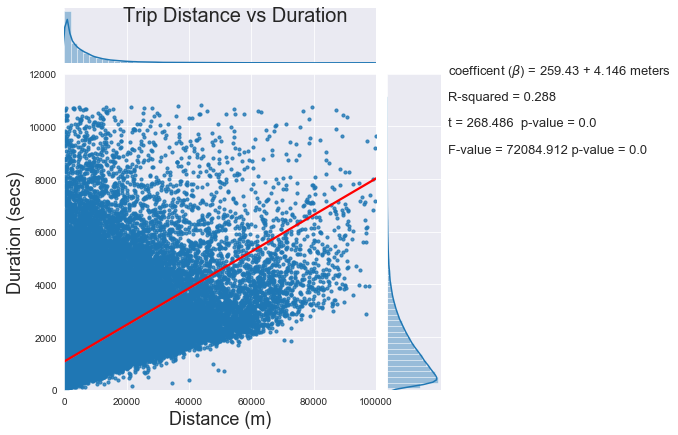

In [127]:
ax = sns.jointplot(gdf.distance_m, gdf.seconds, kind='reg',ci=.95, joint_kws={"scatter_kws": {"s": 10}, "line_kws":{"color":'red'}})
ax.ax_joint.set_ylim(0,12000)
ax.ax_joint.set_xlim(0,100000)
#Histogram of residuals
plt.text(123000, 12000, "coefficent ("  + r'$ \beta $) = ' + str(round(reg.params[0], 3)) + ' + ' + str(round(reg.params[1], 3)) + ' meters', size=13)
plt.text(123000, 11000, "R-squared = " + str(round(reg.rsquared, 3)), size=13)
plt.text(123000, 10000, "t = " + str(round(reg.tvalues[1],3)) + "  p-value = " + str(round(reg.pvalues[1], 3)), size=13)
plt.text(123000, 9000, "F-value = " + str(round(reg.fvalue, 3)) + ' p-value = ' + str(round(reg.f_pvalue, 4)), size=13)
ax.ax_joint.set_ylabel('Duration (secs)', fontsize=18)
ax.ax_joint.set_xlabel('Distance (m)', fontsize=18)
plt.suptitle("Trip Distance vs Duration", size=20)
# plt.savefig("figures/reg_dist_dur.png", bbox_inches='tight')

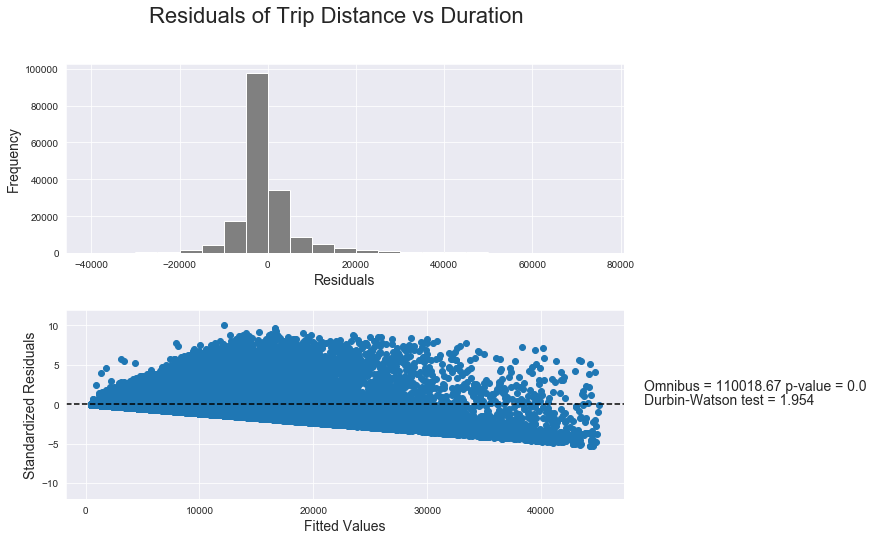

In [128]:
#calculate standardized residuals ourselves
fitted_sr = (reg.resid / np.std(reg.resid)) 
reg.summary()
#Histogram of residuals
# plt.xlabel('Residuals')
#standardized residuals vs fitted values
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(10,8))
plt.subplots_adjust(hspace=.3)

# ax1 = sns.kdeplot(fitted_sr, ax=ax[0])
ax[0].hist(reg.resid, bins=np.arange(-40000, 80000, 5000), color='grey')
ax[0].set_xlabel('Residuals', size=14)
ax[0].set_ylabel('Frequency', size=14)
ax[0].set_title('')
plt.plot(reg.fittedvalues, fitted_sr, 'o')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Fitted Values', size=14)
plt.ylabel('Standardized Residuals', size=14)
dw = reg.summary().tables[2][0][3]
dw = str(dw).replace(' ', '')
plt.ylim(-12,12)
plt.text(49000, 1.75, "Omnibus = " + str(round(reg.diagn['omni'], 3)) + ' p-value = ' + str(round(reg.diagn['omnipv'], 3)), size=14)
plt.text(49000, 0, "Durbin-Watson test = " + str(dw), size=14)

plt.suptitle("Residuals of Trip Distance vs Duration", size=22)
# plt.savefig("figures/res_trip_dur_dis.png", bbox_inches='tight')

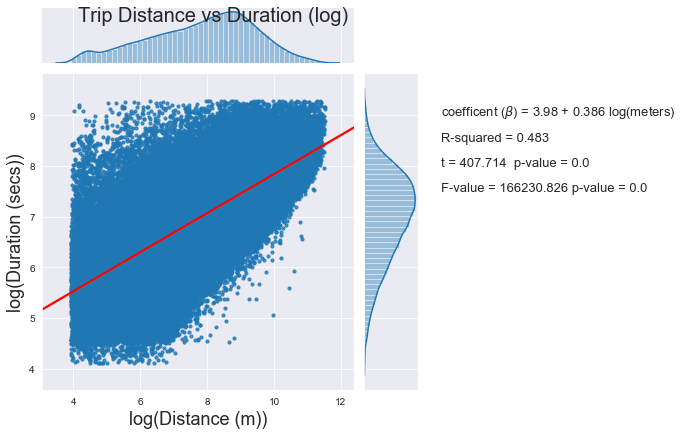

In [129]:
ax = sns.jointplot(gdf.log_dist, gdf.log_dur, kind='reg',ci=.95, joint_kws={"scatter_kws": {"s": 10}, "line_kws":{"color":'red'}})
# ax.ax_joint.set_ylim(0,12000)
# ax.ax_joint.set_xlim(0,100000)
#Histogram of residuals
plt.text(15, 9, "coefficent ("  + r'$ \beta $) = ' + str(round(reg_log.params[0], 3)) + ' + ' + str(round(reg_log.params[1], 3)) + ' log(meters)', size=13)
plt.text(15, 8.5, "R-squared = " + str(round(reg_log.rsquared, 3)), size=13)
plt.text(15, 8, "t = " + str(round(reg_log.tvalues[1],3)) + "  p-value = " + str(round(reg_log.pvalues[1], 3)), size=13)
plt.text(15, 7.5, "F-value = " + str(round(reg_log.fvalue, 3)) + ' p-value = ' + str(round(reg_log.f_pvalue, 4)), size=13)
ax.ax_joint.set_ylabel('log(Duration (secs))', fontsize=18)
ax.ax_joint.set_xlabel('log(Distance (m))', fontsize=18)
plt.suptitle("Trip Distance vs Duration (log)", size=20)
# plt.savefig("figures/reg_dist_dur_log.png", bbox_inches='tight')

In [23]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [40]:
bp_test = het_breuschpagan(reg_log.resid, reg_log.model.exog)

(8757.14320669015, 0.0, 9210.327120693702, 0.0)

In [42]:
labels = ['B-P Test Statistic', 'B-P Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'B-P Test Statistic': 8757.14320669015, 'B-P Test p-value': 0.0, 'F-Statistic': 9210.327120693702, 'F-Test p-value': 0.0}


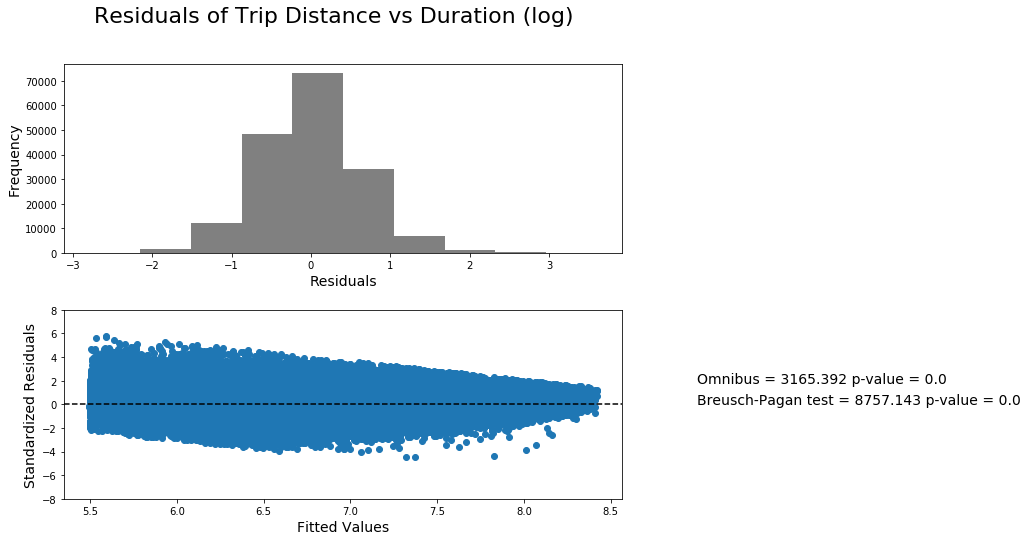

In [49]:
#calculate standardized residuals ourselves
fitted_sr = (reg_log.resid / np.std(reg_log.resid)) 
#Histogram of residuals
# plt.xlabel('Residuals')
#standardized residuals vs fitted values
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(10,8))
plt.subplots_adjust(hspace=.3)

# ax1 = sns.kdeplot(fitted_sr, ax=ax[0])
ax[0].hist(reg_log.resid, color='grey')
ax[0].set_xlabel('Residuals', size=14)
ax[0].set_ylabel('Frequency', size=14)
ax[0].set_title('')
plt.plot(reg_log.fittedvalues, fitted_sr, 'o')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Fitted Values', size=14)
plt.ylabel('Standardized Residuals', size=14)
plt.ylim(-8, 8)
dw = reg_log.summary().tables[2][0][3]
dw = str(dw).replace(' ', '')

plt.text(9, 1.75, "Omnibus = " + str(round(reg_log.diagn['omni'], 3)) + ' p-value = ' + str(round(reg_log.diagn['omnipv'], 3)), size=14)
plt.text(9, 0, "Breusch-Pagan test = " + str(round(bp_test[0], 3)) + " p-value = " + str(bp_test[1]), size=14)

plt.suptitle("Residuals of Trip Distance vs Duration (log)", size=22)
# plt.savefig("figures/res_trip_dur_dis_log.png", bbox_inches='tight')

#### mode, purpose and direction histograms

In [52]:
gdf.groupby('purpose').count()['id_trip']

purpose
cafe                 3115
education            2769
health               1044
leisure              9167
not_available          25
other                1203
pick_up_a_person     1574
returning_home      26819
shops                8363
work                18950
Name: id_trip, dtype: int64

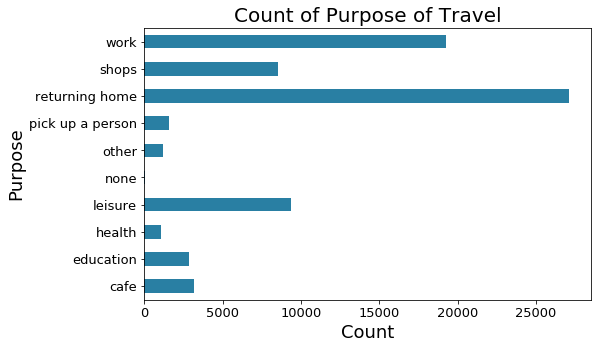

In [127]:
# returning home and work the most popular purpose
fig, ax = plt.subplots(1, figsize=(8,5))
gdf.groupby('purpose').count()['mode'].plot(kind='barh', ax=ax, color='#297fa3')
ax.set_yticklabels(["cafe","education","health","leisure","none","other","pick up a person","returning home","shops","work"], size=13)
plt.xticks(fontsize=13)
ax.set_ylabel("Purpose", size=18)
ax.set_xlabel("Count", size=18)
ax.set_title("Count of Purpose of Travel", size=20)
# plt.savefig("figures/purpose_hist.png", bbox_inches='tight')

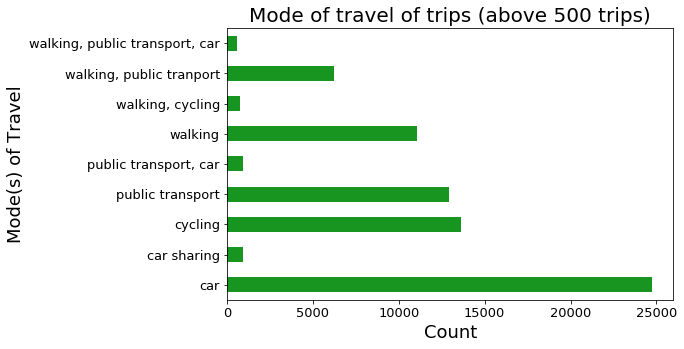

In [111]:
# returning home and work the most popular purpose
fig, ax = plt.subplots(1, figsize=(8,5))
gdf.groupby('mode').count()['purpose'][gdf.groupby('mode').count()['purpose'] >= 500].plot(kind='barh', ax=ax, color='#189420')
ax.set_yticklabels(['car', 'car sharing', 'cycling', 'public transport', 'public transport, car', 'walking', 'walking, cycling', 'walking, public tranport', 'walking, public transport, car'], size=13)
plt.xticks(fontsize=13)
ax.set_ylabel("Mode(s) of Travel", size=18)
ax.set_xlabel("Count", size=18)
ax.set_title("Mode of travel of trips (above 500 trips)", size=20)
# plt.savefig("figures/mode500_hist.png", bbox_inches='tight')

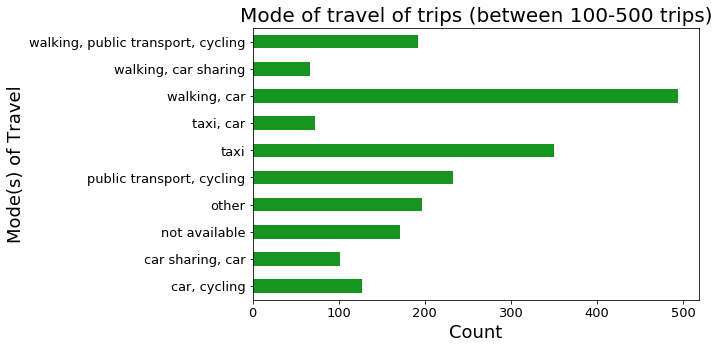

In [110]:
fig, ax = plt.subplots(1, figsize=(8,5))
gdf.groupby('mode').count()['purpose'][(gdf.groupby('mode').count()['purpose'] < 500) & (gdf.groupby('mode').count()['purpose'] > 50)].plot(kind='barh', ax=ax, color='#189420')
ax.set_yticklabels(['car, cycling', 'car sharing, car', 'not available', 'other', 'public transport, cycling', 'taxi',\
                    'taxi, car', 'walking, car', 'walking, car sharing', 'walking, public transport, cycling'], size=13)
plt.xticks(fontsize=13)
ax.set_ylabel("Mode(s) of Travel", size=18)
ax.set_xlabel("Count", size=18)
ax.set_title("Mode of travel of trips (between 100-500 trips)", size=20)
# plt.savefig("figures/mode100to500_hist.png", bbox_inches='tight')

In [13]:
gdf.purpose.unique()

array([None, 'pick_up_a_person', 'work', 'shops', 'returning_home',
       'health', 'leisure', 'education', 'other', 'cafe', 'not_available'],
      dtype=object)

In [108]:
def group_purpose(data, travel_mode, col_order=['cafe', 'education', 'health', 'leisure', 'not_available', 'other',
       'pick_up_a_person', 'returning_home', 'shops', 'work']):
    """
    groups data by defined group also fills in missing columns
    
    Parameters
    ----------
    group1 : pandas.core.series.Series
        a grouped data series
    order : list
        order of the columns
    
    Returns
    -------
    group1 : pandas.core.series.Series
            
    """
    grouped_data = data.groupby(['mode','purpose']).count()['id_trip'][travel_mode]
    total_data = grouped_data.sum()
    print("total data points for '%s': %s" % (travel_mode, total_data))
    grouped_data = grouped_data / grouped_data.sum()
    return grouped_data.reindex(col_order).fillna(0)
    

total data points for 'cycling': 13595


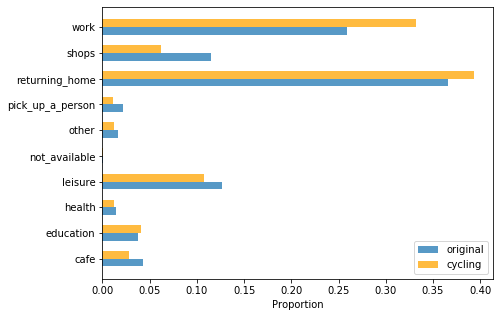

In [109]:
travel_mode = 'cycling'
col_order = ['cafe', 'education', 'health', 'leisure', 'not_available', 'other',\
         'pick_up_a_person', 'returning_home', 'shops', 'work']

grouped_purpose_all = gdf.groupby('purpose').count()['mode'] / gdf.groupby('purpose').count()['mode'].sum()
grouped_purpose_other = group_purpose(gdf, travel_mode, col_order)

fig, ax = plt.subplots(1, figsize=(7,5))
ind = np.arange(len(grouped_purpose_all))
height = .3

ax.barh(y=ind, width=grouped_purpose_all, height=height, alpha=.75)
ax.barh(y=ind+height, width=grouped_purpose_other,height=height, color='orange', alpha=.75)
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(col_order)
ax.set_xlabel("Proportion")

ax.legend(['original',travel_mode]);

In [63]:
pur_mode_df = gdf.groupby(['purpose', "mode"]).count().reset_index()

In [300]:
pur = 'work'
one_pur = pur_mode_df.loc[pur_mode_df.purpose == pur]
pop_mode = one_pur.sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']]

In [343]:
colorblind_pallette = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50","#ffa07a"]

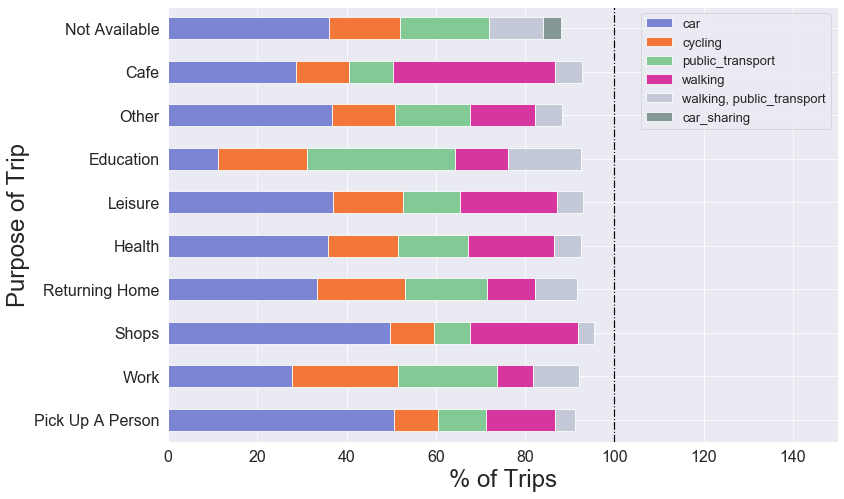

In [344]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(12,8))

gpd.pd.DataFrame([pur_mode_df.loc[pur_mode_df.purpose == pur].sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']][:5].pivot(columns="mode", values='id_trip').sum(axis=0)/pur_mode_df.loc[pur_mode_df.purpose == pur].sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']][:].pivot(columns="mode", values='id_trip').sum(axis=0).sum()*100 for pur in gdf.purpose.unique()[1:]]).plot(kind='barh', stacked=True, ax=ax, color=colorblind_pallette)
ax.set_yticklabels([pur.replace("_", " ").title() for pur in gdf.purpose.unique()[1:]], size=16)
plt.xticks(size=16)
ax.set_xlabel("% of Trips", size=24)
ax.set_ylabel("Purpose of Trip", size=24)
ax.set_xlim(0,150)

ax.legend(loc=1, fontsize=13)
ax.axvline(100,0,10, color='k', linestyle='-.')
# plt.savefig("figures/purpose_vs_percmode.png", bbox_inches='tight')

In [352]:
177938

177938

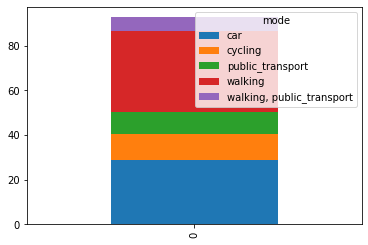

In [268]:
pop_prop = pop_mode[:5].pivot(columns="mode", values='id_trip').sum(axis=0)/pop_mode.sum(axis=0)['id_trip']
gpd.pd.DataFrame([pop_prop]).plot(kind='bar', stacked=True)

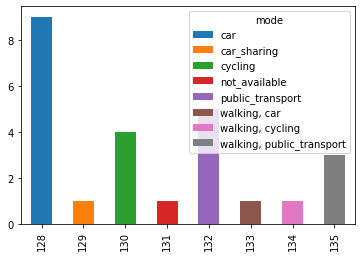

In [212]:
pop_mode.pivot(columns="mode", values='id_trip').fillna(0).plot(kind='bar', stacked=True)

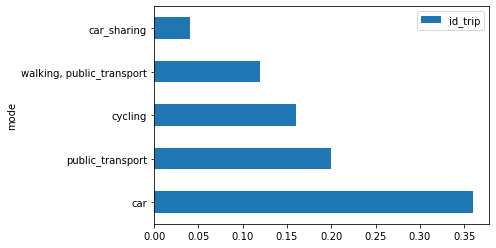

In [170]:
(pop_mode.set_index('mode')[:5]/ pop_mode.set_index('mode')['id_trip'].sum()).plot(kind='barh', stacked=True)

In [141]:
for pur in gdf.purpose.unique():
    one_pur = pur_mode_df.loc[pur_mode_df.purpose == pur]
    pop_mode = one_pur.sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']]
    print(pur, pop_mode[:5])

None Empty DataFrame
Columns: [mode, id_trip]
Index: []
pick_up_a_person                           mode  id_trip
164                        car      798
180                    walking      244
175           public_transport      167
170                    cycling      155
185  walking, public_transport       70
work                           mode  id_trip
275                        car     5279
286                    cycling     4495
293           public_transport     4190
313  walking, public_transport     1964
303                    walking     1520
shops                           mode  id_trip
246                        car     4160
264                    walking     2027
253                    cycling      832
258           public_transport      664
271  walking, public_transport      298
returning_home                           mode  id_trip
192                        car     8935
204                    cycling     5321
214           public_transport     4890
222                  

In [129]:
def get_top_modes(pur, top=1):
    one_pur = pur_mode_df.loc[pur_mode_df.purpose == pur]
    pop_mode = one_pur.sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']]
    return pop_mode.values[:top], pop_mode.values[:top,1]/sum(pop_mode.values[:top,1])

In [115]:
one_pur.sort_values(by='id_trip', ascending=False)[['mode', 'id_trip']]

,mode,id_trip
17,walking,1128
0,car,893
7,cycling,371
12,public_transport,309
28,"walking, public_transport",188
2,car_sharing,63
24,"walking, cycling",33
18,"walking, car",26
14,taxi,26
13,"public_transport, car",12


In [133]:
prop_mode*100

array([50.0, 27.77777777777778, 22.22222222222222], dtype=object)

In [135]:
for pr in gdf.purpose.unique():
    top_3, prop_mode = get_top_modes(pr, top=3)
    print(pr,prop_mode)

None []
pick_up_a_person [0.6600496277915633 0.20181968569065342 0.1381306865177833]
work [0.37804354053279865 0.32189916929246637 0.30005729017473504]
shops [0.59267701951845 0.2887875765778601 0.11853540390368998]
returning_home [0.4666771127128382 0.2779170583933981 0.25540582889376373]
health [0.5060893098782138 0.2706359945872801 0.2232746955345061]
leisure [0.4960445355991796 0.29197187225314974 0.21198359214767068]
education [0.47767393561786087 0.28712357217030116 0.235202492211838]
other [0.5395858708891595 0.24604141291108406 0.2143727161997564]
cafe [0.47157190635451507 0.3733277591973244 0.15510033444816054]
not_available [0.5 0.2777777777777778 0.2222222222222222]


## directionality

In [18]:
gdf.loc[200:200].plot()
mplleaflet.display(crs=CAN_LAM)

In [19]:
ind = 30
plt.scatter(gdf.geometry[200].xy[0][:ind], gdf.geometry[200].xy[1][:ind])
mplleaflet.display(crs=CAN_LAM)

In [20]:
gdf_4326 = gdf.to_crs(crs=WGS_84)

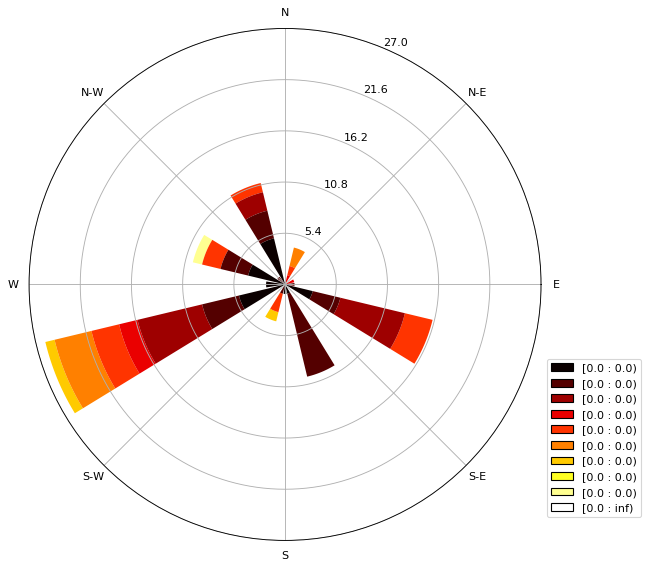

(239.90063856482718, 0.03635896413428302)

In [21]:
direction_functions.mean_direction(gdf_4326.geometry[200], plot_windrose=True)

In [128]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...


In [207]:
# create a column that is just 1 
gdf['alt_mag'] = 1 

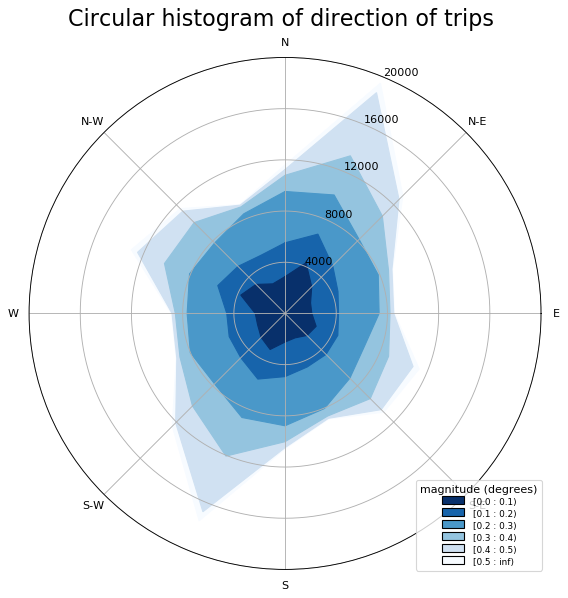

In [220]:
ax = WindroseAxes.from_ax()
ax.contourf(gdf.direction,gdf.magnitude, edgecolor='white', bins=6, cmap=cm.Blues_r)
ax.legend()
ax.set_legend(title='magnitude (degrees)', loc=4, labelspacing=.2)
ax.set_yticks(np.arange(4000, 24000, step=4000))
ax.set_yticklabels([4000,8000,12000,16000,20000]);
ax.set_title("Circular histogram of direction of trips ", size=20)
# plt.savefig("figures/windrose_all.png", bbox_inches='tight')

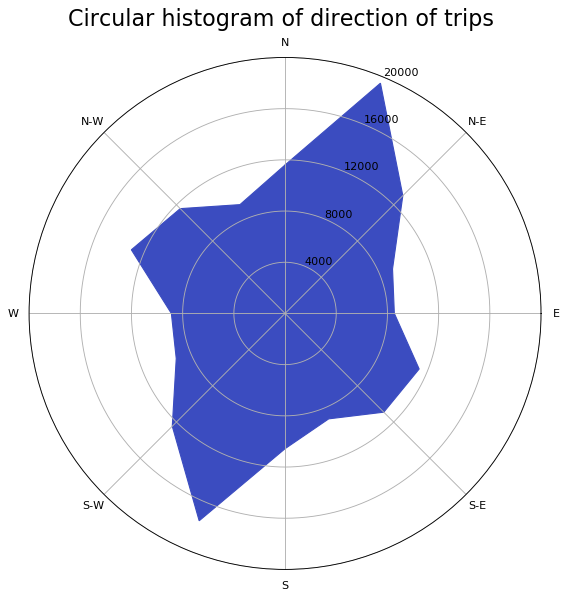

In [223]:
ax = WindroseAxes.from_ax()
ax.contourf(gdf.direction,gdf.alt_mag, edgecolor='white', bins=1, cmap=cm.coolwarm)

ax.set_yticks(np.arange(4000, 24000, step=4000))
ax.set_yticklabels([4000,8000,12000,16000,20000]);
ax.set_title("Circular histogram of direction of trips ", size=20)
# plt.savefig("figures/windrose_all_onecol.png", bbox_inches='tight')

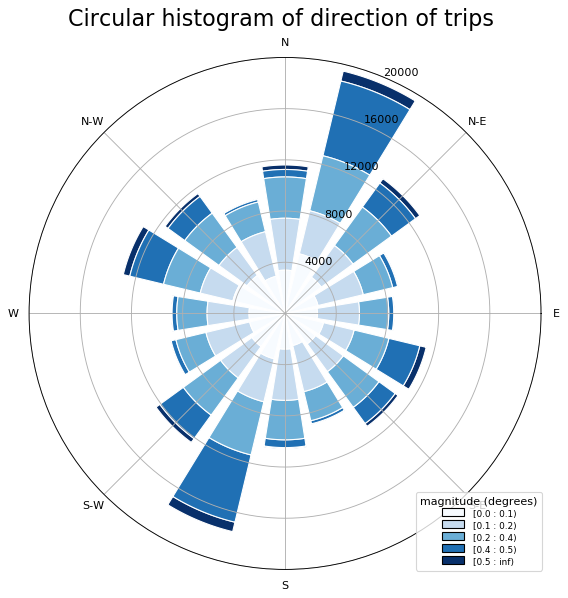

In [230]:
ax = WindroseAxes.from_ax()
ax.bar(gdf.direction,gdf.magnitude, edgecolor='white', bins=5, cmap=cm.Blues)
ax.legend()
ax.set_legend(title='magnitude (degrees)', loc=4, labelspacing=.2)
ax.set_yticks(np.arange(4000, 24000, step=4000))
ax.set_yticklabels([4000,8000,12000,16000,20000]);
ax.set_title("Circular histogram of direction of trips ", size=20)
# plt.savefig("figures/windrose_all_bar.png", bbox_inches='tight')

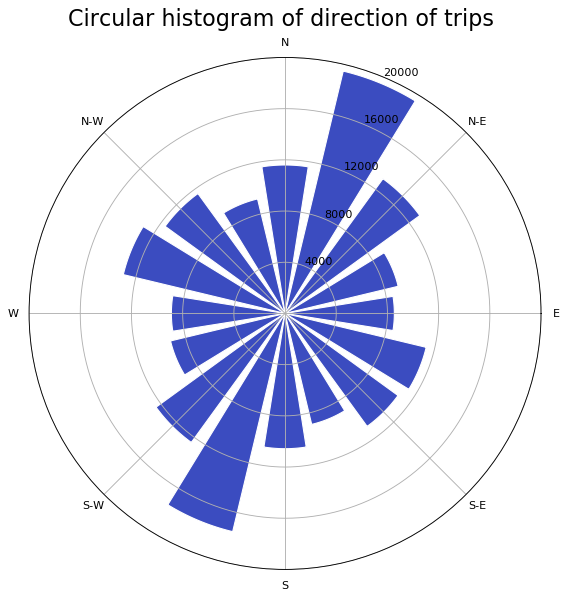

In [225]:
ax = WindroseAxes.from_ax()
ax.bar(gdf.direction,gdf.alt_mag, edgecolor='white', bins=1, cmap=cm.coolwarm)

ax.set_yticks(np.arange(4000, 24000, step=4000))
ax.set_yticklabels([4000,8000,12000,16000,20000]);
ax.set_title("Circular histogram of direction of trips ", size=20)
# plt.savefig("figures/windrose_all_onecol_bar.png", bbox_inches='tight')

# Investigate the other data

In [31]:
mtl_culture_sites = gpd.read_file('../data/lieuxculturels.json')
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')
mtl_roads = gpd.read_file('../data/mtl_roads.json')
mtl_parking_stations = gpd.read_file('../data/signalisation_stationnement.geojson')
mtl_census_tract = gpd.read_file("../shapes/mtl_census_tract.geojson") # areas of montreal

### Cultural Sites

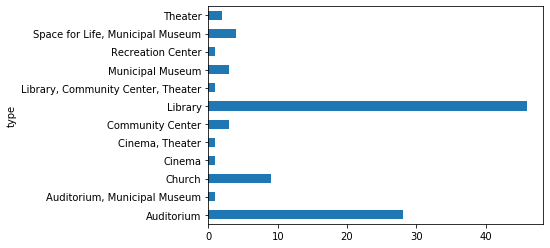

In [258]:
mtl_culture_sites.groupby(['type']).count()['name'].plot(kind='barh')

### Land Use

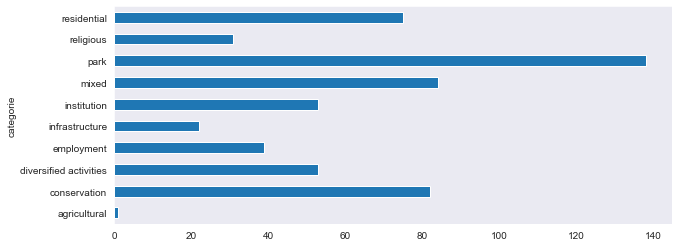

In [32]:
fig, ax = plt.subplots(1, figsize=(10,4))
mtl_land_use.groupby('categorie').count()['geometry'].plot(kind='barh', ax=ax)
# plt.savefig("figures/landuse_bar.png", bbox_inches='tight')

matplotlib.colors.ListedColormap

In [41]:
import matplotlib

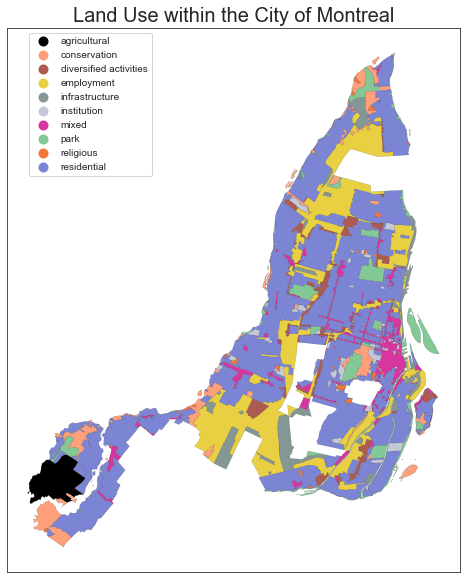

In [64]:
sns.set_style('white')
fig, ax = plt.subplots(1, figsize=(12,10))
colorblind_pallette = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
colorblind_pallette.reverse()
colorblind_pallette = matplotlib.colors.ListedColormap(colorblind_pallette)
mtl_land_use.plot('categorie', legend=True, ax=ax, cmap=colorblind_pallette, edgecolor='k', linewidth=.1)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.13, 0.8, 0.2, 0.2))
ax.set_xticklabels([""])
ax.set_yticklabels([""])
ax.set_title("Land Use within the City of Montreal", size=20)
# plt.savefig("figures/landuse_map.png", bbox_inches='tight')

## Roads

##### Class
-	Class 9 - Projected Street 
-	Class 8 - Highways 
-	Class 7 - Main arteries 
-	Class 6 - Secondary arteries 
-	Class 5 - Collectors 
-	Class 4 - Private 
-	Class 3 - Wharf 
-	Class 2 - Business Places 
-	Class 1 - Certain pedestrian routes 
- 	Class 0 - Local Streets 

##### Circ-Direction
-	1 -> one way in the direction of digitization 
-	-1 -> one way in the opposite direction of digitization 
-	0 -> double meaning 


In [26]:
mtl_roads.head()

,ID_TRC,DEB_GCH,FIN_GCH,ARR_GCH,CIRC_DIRECTION,CLASS,LIE_VOIE,PATH_TYPE,DIRECTION,NOM_VOIE,DEB_DRT,FIN_DRT,ARR_DRT,LIM_GCH,LIM_DRT,geometry
0,1010001,12320,12340,Ahuntsic-Cartierville,0,0,None,avenue,None,Adhémar-Mailhiot,12323,12335,Ahuntsic-Cartierville,Montréal,Montréal,LINESTRING (7618007.998702482 1242606.68334191...
1,1010004,5530,5570,Ahuntsic-Cartierville,0,0,None,square,None,D'Aiguillon,5475,5625,Ahuntsic-Cartierville,Montréal,Montréal,LINESTRING (7620364.86145121 1244317.480805032...
2,1010005,7750,7830,Ahuntsic-Cartierville,0,0,None,avenue,None,Albert-LeSage,7745,7805,Ahuntsic-Cartierville,Montréal,Montréal,LINESTRING (7618113.292375704 1243281.68559435...
3,1010006,12200,12238,Ahuntsic-Cartierville,0,0,None,avenue,None,Albert-Prévost,0,0,Ahuntsic-Cartierville,Montréal,Montréal,LINESTRING (7618313.639050498 1242957.74353570...
4,1010007,12240,12270,Ahuntsic-Cartierville,0,0,None,avenue,None,Albert-Prévost,0,0,Ahuntsic-Cartierville,Montréal,Montréal,LINESTRING (7618243.153371288 1242991.22533476...


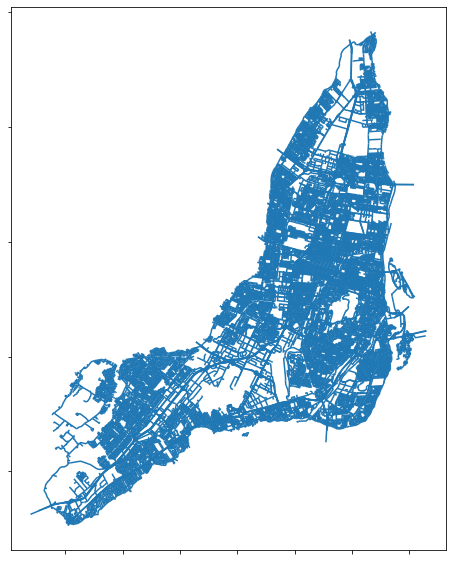

In [296]:
fig, ax = plt.subplots(1, figsize=(12, 10))
mtl_roads.plot(ax=ax)
ax.set_xticklabels("")
ax.set_yticklabels("")
plt.savefig("figures/road.png", bbox_inches='tight')

## Parking Stations

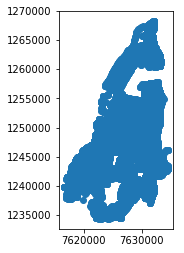

In [27]:
mtl_parking_stations.plot()

In [259]:
len(gdf['purpose'].unique())

11

## investigate downtown and rushhour

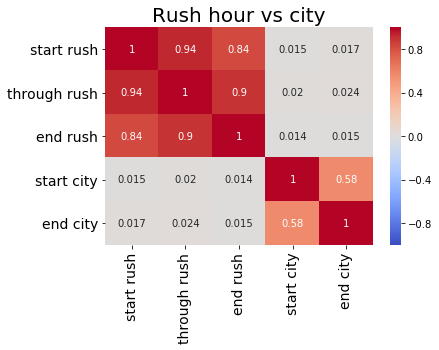

In [71]:
ax = sns.heatmap(gdf[["startrush","thrurush","endrush","start_down","end_downto"]].corr(), annot=True, cmap='coolwarm', vmin=-1)
ax.set_xticklabels(["start rush","through rush","end rush","start city","end city"], size=14)
ax.set_yticklabels(["start rush","through rush","end rush","start city","end city"], size=14)
ax.set_title("Rush hour vs city", size=20)
# plt.savefig("figures/rushhourvscity_corrmat.png", bbox_inches='tight')

In [13]:
gdf.startrush.corr(gdf.end_downto)

0.017456947689271026

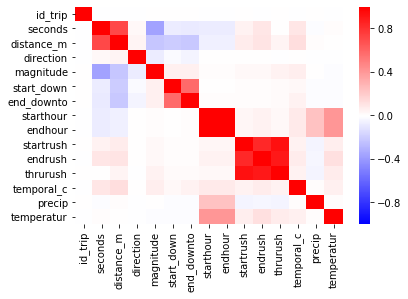

In [55]:
sns.heatmap(gdf.corr('spearman'), vmin=-1, vmax=1, cmap='bwr')

In [40]:
gdf.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'lda_word', 'temporal_c', 'start_wgs', 'end_wgs',
       'start_can', 'end_can', 'geometry'],
      dtype='object')

In [22]:
gdf = gdf.dropna(subset=['purpose'])

In [23]:
mask = (gdf.startrush | gdf.endrush | gdf.thrurush)
gdf.loc[np.where(mask)]

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,lda_word,temporal_c,precip,temperatur,land_use,start_wgs,end_wgs,start_can,end_can,geometry
0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,150744.0,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862.0,9935.922336,85.310969,0.304086,E,...,"Monday_6, pick_up_a_person",1.0,0.0,18.353766,"['residential', 'employment', 'diversified act...",POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
rush = gdf.loc[(gdf.startrush == 1)|(gdf.endrush == 1)|(gdf.thrurush == 1)]
non_rush = gdf.loc[(gdf.startrush != 1)&(gdf.endrush != 1)&(gdf.thrurush != 1)]

city = gdf.loc[(gdf.start_down == 1)|(gdf.end_downto == 1)]
non_city = gdf.loc[(gdf.start_down != 1)&(gdf.end_downto != 1)]

In [25]:
non_rush.purpose.value_counts()

returning_home      12525
work                 5352
shops                5162
leisure              4454
cafe                 1686
education            1089
pick_up_a_person      692
other                 614
health                499
not_available          11
Name: purpose, dtype: int64

In [41]:
print(gdf.startrush.value_counts())
print(gdf.thrurush.value_counts())
print(gdf.endrush.value_counts())
print(gdf.start_down.value_counts())
print(gdf.end_downto.value_counts())

1    36785
0    36244
Name: startrush, dtype: int64
0    38650
1    34379
Name: thrurush, dtype: int64
1    38539
0    34490
Name: endrush, dtype: int64
1    63811
0     9218
Name: start_down, dtype: int64
1    64136
0     8893
Name: end_downto, dtype: int64


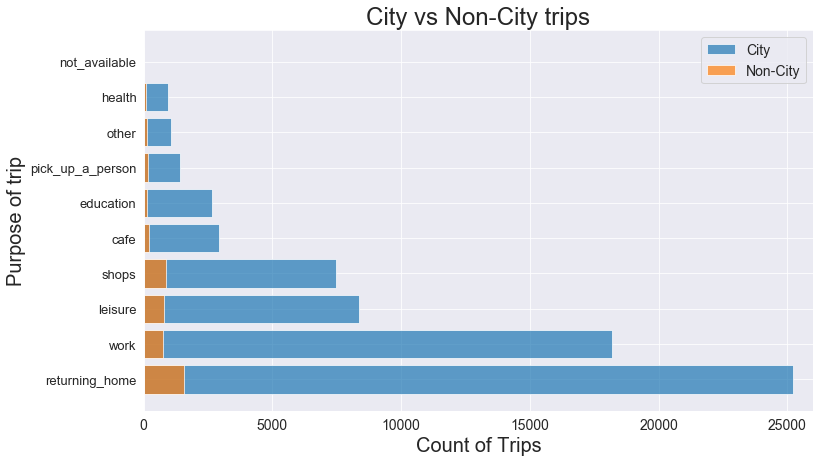

In [27]:
fig, ax = plt.subplots(1, figsize=(12,7))
plt.barh(city.purpose.value_counts().keys(), city.purpose.value_counts().values.tolist(), alpha=.7)
plt.barh(non_city.purpose.value_counts().keys(), non_city.purpose.value_counts().values.tolist(), alpha=.7)
plt.legend(["City",'Non-City'], fontsize=14)
plt.xticks(size=14)
plt.yticks(size=13)
plt.ylabel("Purpose of trip", size=20)
plt.xlabel("Count of Trips", size=20)
plt.title("City vs Non-City trips", size=24)
plt.xlim(0,26000)
# plt.savefig("figures/city_vs_ncity_trips_purpose.png", bbox_inches='tight')

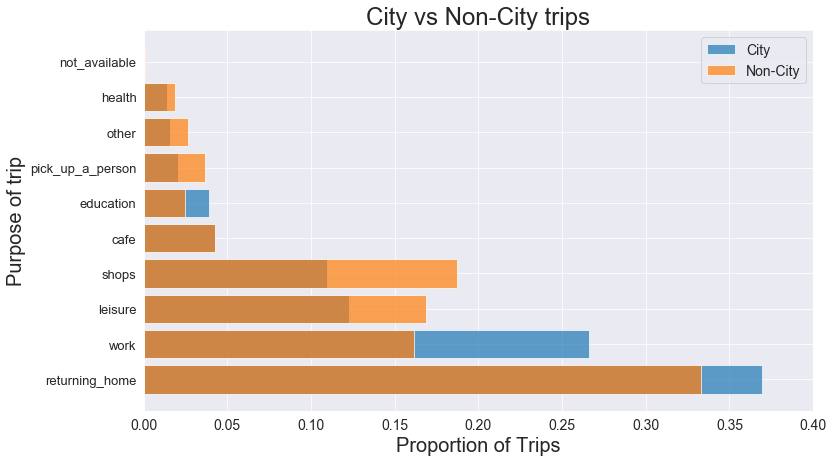

In [18]:
fig, ax = plt.subplots(1, figsize=(12,7))
plt.barh(city.purpose.value_counts().keys(), city.purpose.value_counts().values/sum(city.purpose.value_counts().values).tolist(), alpha=.7)
plt.barh(non_city.purpose.value_counts().keys(), non_city.purpose.value_counts().values/sum(non_city.purpose.value_counts().values).tolist(), alpha=.7)
plt.legend(["City",'Non-City'], fontsize=14)
plt.xticks(size=14)
plt.yticks(size=13)
plt.ylabel("Purpose of trip", size=20)
plt.title("City vs Non-City trips", size=24)
plt.xlabel("Proportion of Trips", size=20)
plt.xlim(0,0.4)
# plt.savefig("figures/city_vs_ncity_trips_purpose_prop.png", bbox_inches='tight')

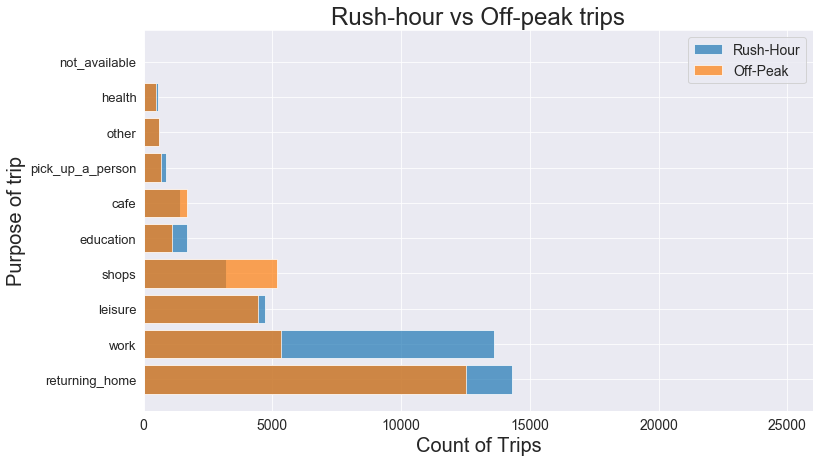

In [19]:
fig, ax = plt.subplots(1, figsize=(12,7))
plt.barh(rush.purpose.value_counts().keys(), rush.purpose.value_counts().values.tolist(), alpha=.7)
plt.barh(non_rush.purpose.value_counts().keys(), non_rush.purpose.value_counts().values.tolist(), alpha=.7)
plt.legend(["Rush-Hour",'Off-Peak'], fontsize=14)
plt.xticks(size=14)
plt.yticks(size=13)
plt.ylabel("Purpose of trip", size=20)
plt.title("Rush-hour vs Off-peak trips", size=24)
plt.xlim(0,26000)
plt.xlabel("Count of Trips", size=20)
# plt.savefig("figures/rh_vs_op_trips_purpose.png", bbox_inches='tight')

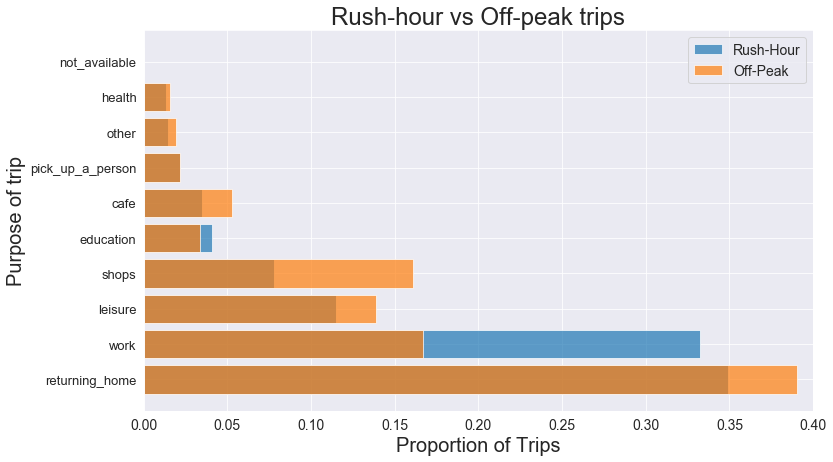

In [20]:
fig, ax = plt.subplots(1, figsize=(12,7))
plt.barh(rush.purpose.value_counts().keys(), rush.purpose.value_counts().values/sum(rush.purpose.value_counts().values).tolist(), alpha=.7)
plt.barh(non_rush.purpose.value_counts().keys(), non_rush.purpose.value_counts().values/sum(non_rush.purpose.value_counts().values).tolist(), alpha=.7)
plt.legend(["Rush-Hour",'Off-Peak'], fontsize=14)
plt.xticks(size=14)
plt.yticks(size=13)
plt.ylabel("Purpose of trip", size=20)
plt.title("Rush-hour vs Off-peak trips", size=24)
plt.xlabel("Proportion of Trips", size=20)
plt.xlim(0,0.4)
# plt.savefig("figures/rh_vs_op_trips_purpose_prop.png", bbox_inches='tight')

# create data for Ripley's K
Note: move this back 

In [6]:
mtl_greater = mtl_greater.dissolve(by="CMANAME")

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point 7592536.4285895023 1235564.8772064648 at 7592536.4285895023 1235564.8772064648
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point 7592536.4285895023 1235564.8772064648 at 7592536.4285895023 1235564.8772064648
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point 7592536.4285895023 1235564.8772064648 at 7592536.4285895023 1235564.8772064648


ValueError: No Shapely geometry can be created from null value

In [7]:
def plot_kde_city(pnt_time, title, savefile):
    fig, ax = plt.subplots(1, figsize=(10,6))
    mtl_greater.plot(color='grey', edgecolor='black', alpha=.1, ax=ax)
    sns.kdeplot(pnt_time.x,pnt_time.y, shade=False, cmap='viridis', gridsize=1000, ax=ax)
    plt.xticks([]);
    plt.yticks([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    plt.title(title, size=20)
    plt.savefig("figures/{0}.png".format(savefile), bbox_inches='tight')
    plt.close()

In [8]:
rush = gdf.loc[(gdf.startrush == 1)|(gdf.endrush == 1)|(gdf.thrurush == 1)]
non_rush = gdf.loc[(gdf.startrush != 1)&(gdf.endrush != 1)&(gdf.thrurush != 1)]

city = gdf.loc[(gdf.start_down == 1)|(gdf.end_downto == 1)]
non_city = gdf.loc[(gdf.start_down != 1)&(gdf.end_downto != 1)]

start_city = gdf.loc[(gdf.start_down == 1)]
start_non_city = gdf.loc[(gdf.start_down != 1)]

In [384]:
# overall endpoints
# end points of trips starting in the city
pnt_time = pd.DataFrame(start_non_city.apply(lambda row: (row.end_can.x, row.end_can.y) , axis=1))
pnt_time = pnt_time[0].apply(pd.Series)
pnt_time.columns = ["x","y"]#,"t"]
pnt_time.reset_index(drop=True, inplace=True)
pnt_time['geometry'] = pnt_time.apply(lambda row: shapely.geometry.Point(row.x,row.y), axis=1)
# gpd.GeoDataFrame(pnt_time).to_file("../shapes/cafe_pnts.shp")

In [ ]:
start_city.purpose.unique()

In [16]:
# end points of trips starting overall
# for pur in gdf.purpose.unique()[1:2]:
#     pnt_time = pd.DataFrame(gdf.loc[gdf.purpose == pur].apply(lambda row: (row.end_can.x, row.end_can.y) , axis=1))
#     pnt_time = pnt_time[0].apply(pd.Series)
#     pnt_time.columns = ["x","y"]#,"t"]
#     pnt_time.reset_index(drop=True, inplace=True)
#     pnt_time['geometry'] = pnt_time.apply(lambda row: shapely.geometry.Point(row.x,row.y), axis=1)
#     plot_kde_city(pnt_time, title="KDE: {0}".format(pur.replace("_"," ").title()), savefile="{0}_kde_ov".format(pur))
#     print(pur)


pick_up_a_person


In [13]:
print("done!")

done!
